# Investigate which Architecture is Optimal for the Dataset
Examining the number of layers, number of nodes per layer and other hyperparameters.

In [1]:
import joblib

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState, MT19937, SeedSequence
import pandas as pd
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf

## Constraints
To reduce the number of variables to test, some values will be kept the same:
- `StandardScaler` will be used to scale the data.
- Activation function for hidden layers will be set to `relu`
- Activation function for output layer will be set to `sigmoid`
- Batch size and number of epochs

## Import & Preprocess Data

In [2]:
params = {
    'random_state': 42,
    'num_epochs': 500,
    'batch_size': 32,
}

rs = RandomState(MT19937(SeedSequence(params['random_state'])))

In [3]:
df_heart = pd.read_csv('data/heart_failure_clinical_records_dataset.xls')

In [4]:
df_heart.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
X = df_heart.drop(columns='DEATH_EVENT')
y = df_heart['DEATH_EVENT'].to_numpy()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=params['random_state'], stratify=y
)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## Define the Model

Helper functions to choose parameters for a model

In [8]:
def select_model_params(param_dist: dict) -> dict:
    return {
        'input_size': np.random.choice(param_dist['input_size']),
        # Probability distribution for num_hidden_layers 
        # to prevent 0 from being chosen too often
        'num_hidden_layers': np.random.choice(param_dist['num_hidden_layers'], p=[0.1, 0.3, 0.3, 0.3]),
        'nodes_layer_1': np.random.choice(param_dist['nodes_layer_1']),
        'nodes_layer_2': np.random.choice(param_dist['nodes_layer_2']),
        'nodes_layer_3': np.random.choice(param_dist['nodes_layer_3']),
        'dropout_rate': np.random.choice(param_dist['dropout_rate']),
        'loss': np.random.choice(param_dist['loss']),
        'optimizer': np.random.choice(param_dist['optimizer']),
        'learning_rate': np.random.choice(param_dist['learning_rate'])
    }


def select_fit_params(param_dist: dict) -> tuple[int, int]:
    return (
        np.random.choice(param_dist['batch_size']),
        np.random.choice(param_dist['epochs']),
    )

Functions to create the model

In [9]:
def create_model(
    input_size: int = 0,
    num_hidden_layers: int = 0,
    nodes_layer_1: int = 0,
    nodes_layer_2: int = 0,
    nodes_layer_3: int = 0,
    dropout_rate: float = 0,
    loss = None,
    optimizer = None,
    learning_rate: float = 0
) -> tf.keras.models.Sequential:
    
    # create model for KerasClassifier
    structure = np.array([nodes_layer_1, nodes_layer_2, nodes_layer_3])[:num_hidden_layers]
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((input_size,)))                    # input
    add_hidden_layers(model, structure, dropout_rate=dropout_rate)  # hidden
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))       # output
    
    optimizer._set_hyper('learning_rate', learning_rate)

    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
        ]
    )

    return model


def add_hidden_layers(
    model: tf.keras.models.Sequential,
    structure,
    activation: str = 'relu',
    dropout_rate: float = 0.0
):
    for layer in structure:
        model.add(tf.keras.layers.Dense(layer, activation=activation))
        model.add(tf.keras.layers.Dropout(dropout_rate))

## Model Selection

In [10]:
def print_final_results(best_score, best_params):
    print('\n==============================')
    print('Final Results')
    print(f'Best score: {best_score:.3f}')
    for name, value in best_params.items():
        if isinstance(value, float):
            print(f'Best {name}: {value:.3f}')
        elif name == 'loss':
            print(f'Best {name}: {value.__class__.__name__}')
        elif name == 'optimizer':
            print(f'Best {name}: {value.__class__.__name__}')
        else:
            print(f'Best {name}: {value}')

Define early stopping conditions

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, min_delta=1e-6, patience=3
)

Choose hyperparameter distributions

In [12]:
param_dist = {
    'random_state': 42,
    'input_size': [X.columns.size],
    'num_hidden_layers': np.arange(0, 3 + 1, step=1),
    'nodes_layer_1': np.arange(3, 24, step=3),
    'nodes_layer_2': np.arange(3, 24, step=3),
    'nodes_layer_3': np.arange(3, 24, step=3),
    'dropout_rate': np.linspace(0.0, 0.6, num=6),
    'loss': [tf.keras.losses.BinaryCrossentropy()],
    'optimizer': [tf.keras.optimizers.SGD(), tf.keras.optimizers.Adam()],
    'learning_rate': np.logspace(-3, -1, num=10),
    'epochs': [100, 200, 300],
    'batch_size': [16, 32, 64],
}

Random Search & Cross Validate Models to Find the Best One

In [13]:
def random_model_cv(n_iter: int = 10, n_splits: int = 5, scoring: callable = None, verbosity: int = 2):
    
    best_score = 0.0

    for i in range(n_iter):
        histories = []
        scores = np.zeros((n_splits,), dtype=float)

        # Select parameters to use for random search
        model_params = select_model_params(param_dist)
        batch_size, epochs = select_fit_params(param_dist)

        # use StratifiedKFold to split the data into training and testing sets
        for k, (train_index, val_index) in \
            enumerate(
                StratifiedKFold(
                    n_splits=n_splits, shuffle=True, 
                    random_state=param_dist['random_state']
                ).split(X_train, y_train)
            ):
            # Separate train and validation sets using the indices
            X_train_fold, X_val = X_train[train_index], X_train[val_index]
            y_train_fold, y_val = y_train[train_index], y_train[val_index]

            # Clear old models to free up memory
            tf.keras.backend.clear_session()

            model = create_model(**model_params)

            # Choose most verbose setting to get the TF training output
            if verbosity > 2:
                print_k_fold_training = 1
            else:
                print_k_fold_training = 0

            # Fit the model
            history = model.fit(
                X_train_fold, y_train_fold, validation_data=(X_val, y_val),
                batch_size=batch_size,
                epochs=epochs,
                use_multiprocessing=True,
                workers=-1,
                verbose=print_k_fold_training
            )

            # Save the model history
            histories.append(history)

            # Calculate scores for the model
            threshold = 0.5
            y_pred = (model.predict(X_val) > threshold).astype(int)
            if scoring is None or scoring.startswith('acc'):
                scores[k] = accuracy_score(y_val, y_pred) # f1_score is default
            elif scoring.startswith('f1'):
                scores[k] = f1_score(y_val, y_pred)
            else:
                raise ValueError(f'Unknown scoring method: {scoring}')

        # Score the model based on the average of all K folds
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_estimator = model
            best_history = histories
            best_params = model_params
            best_params['batch_size'] = batch_size
            best_params['epochs'] = epochs
            # Set layer neurons to zero if the layer 
            # number is higher than the number of layers
            if best_params['num_hidden_layers'] < 3:
                best_params['nodel_layer_3'] = 0
            if best_params['num_hidden_layers'] < 2:
                best_params['nodel_layer_2'] = 0
            if best_params['num_hidden_layers'] < 1:
                best_params['nodel_layer_1'] = 0

        # Print if verbose
        if verbosity > 1:
            print('==============================')
            print('Random Model', i)
            print(f'score: {mean_score:.3f}')
            print(f'std  : {scores.std():.3f}')

    if verbosity > 0:
        print_final_results(best_score, best_params)

    return best_estimator, best_history, best_params

In [15]:
# run random_model_cv in parallel
best_estimator, best_history, best_params = random_model_cv(n_iter=10, n_splits=4, scoring='f1')


2/2 [==============================] - 0s 2ms/step
Random Model 0
score: 0.683
std  : 0.070
2/2 [==============================] - 0s 2ms/step
Random Model 1
score: 0.610
std  : 0.112
2/2 [==============================] - 0s 2ms/step
Random Model 2
score: 0.602
std  : 0.094
2/2 [==============================] - 0s 2ms/step
Random Model 3
score: 0.660
std  : 0.076
2/2 [==============================] - 0s 2ms/step
Random Model 4
score: 0.755
std  : 0.096
2/2 [==============================] - 0s 1ms/step
Random Model 5
score: 0.658
std  : 0.052
2/2 [==============================] - 0s 998us/step
Random Model 6
score: 0.612
std  : 0.040
2/2 [==============================] - 0s 999us/step
Random Model 7
score: 0.711
std  : 0.050
2/2 [==============================] - 0s 2ms/step
Random Model 8
score: 0.687
std  : 0.091
2/2 [==============================] - 0s 2ms/step
Random Model 9
score: 0.584
std  : 0.135

Final Results
Best score: 0.755
Best input_size: 12
Best num_hidden_layers:

## Plot the Results

In [ ]:
def plot_epochs(history: dict, variable: str):
    plt.plot(history[variable])
    plt.plot(history['val_' + variable])
    plt.title(f'Model {variable.capitalize()} Across Training Epochs')
    plt.ylabel(variable.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

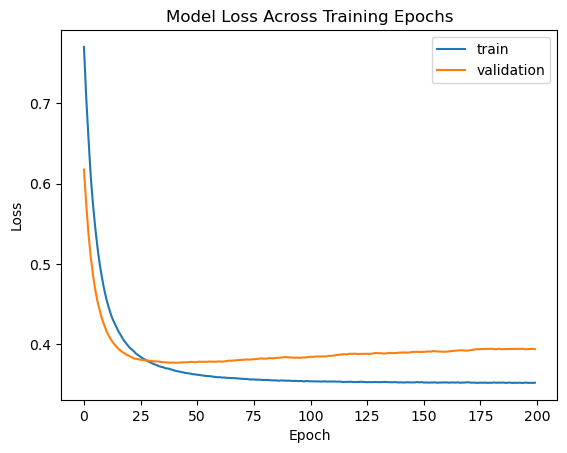

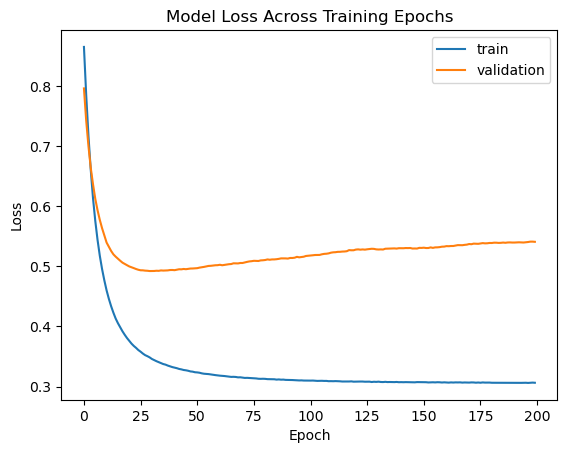

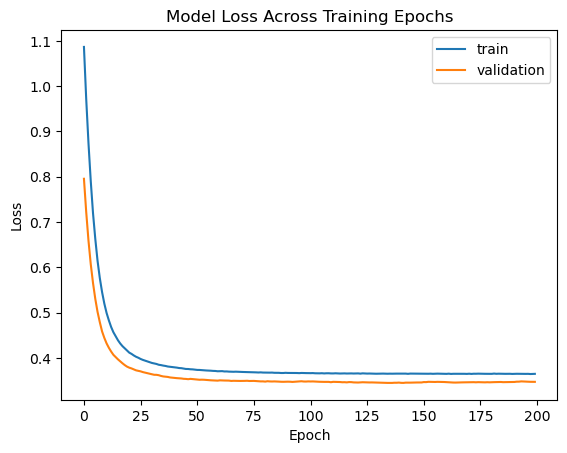

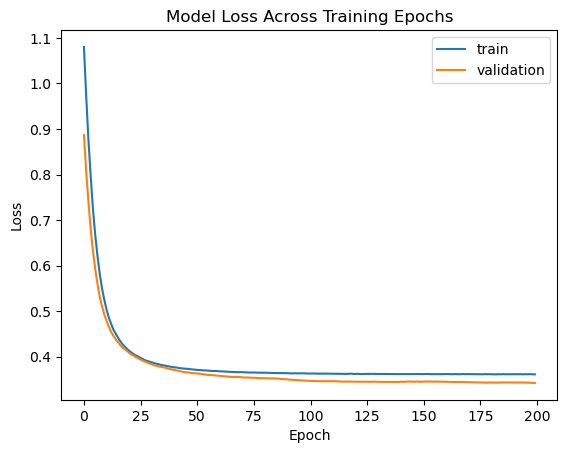

In [ ]:
for history in best_history:
    plot_epochs(history.history, 'loss')

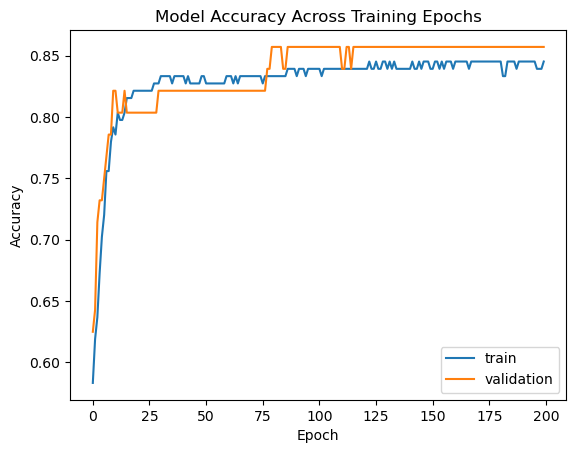

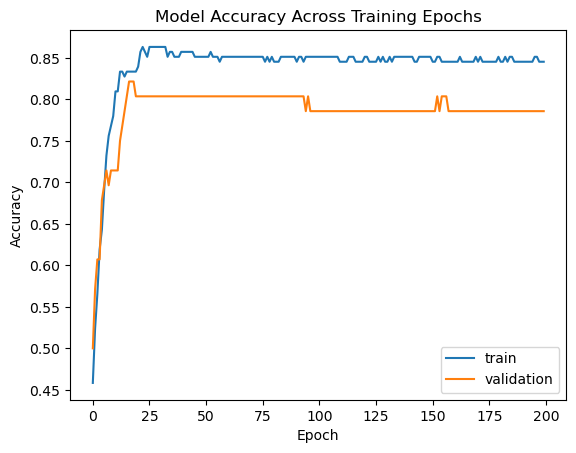

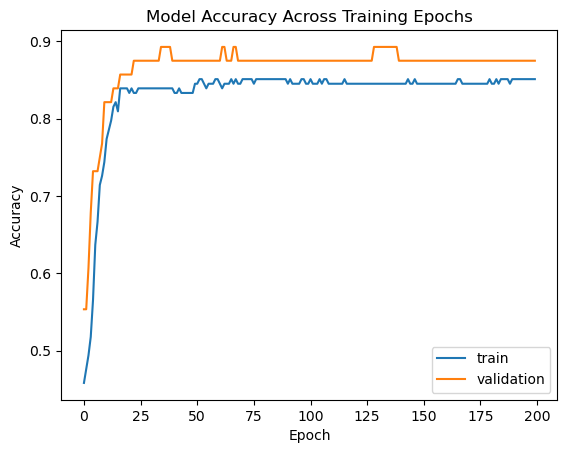

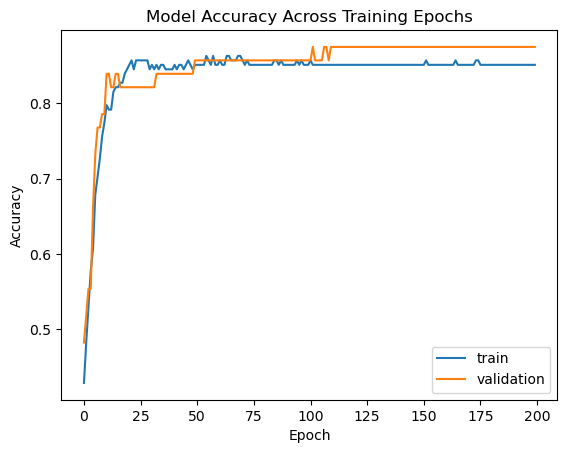

In [ ]:
for history in best_history:
    plot_epochs(history.history, 'accuracy')

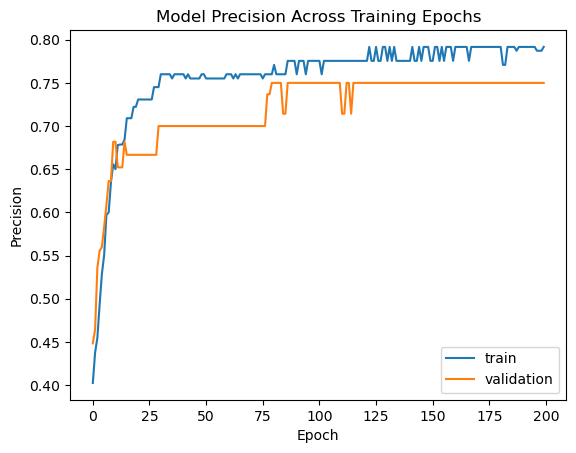

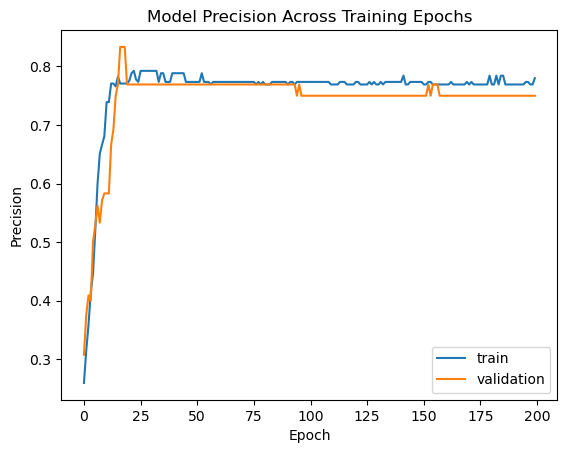

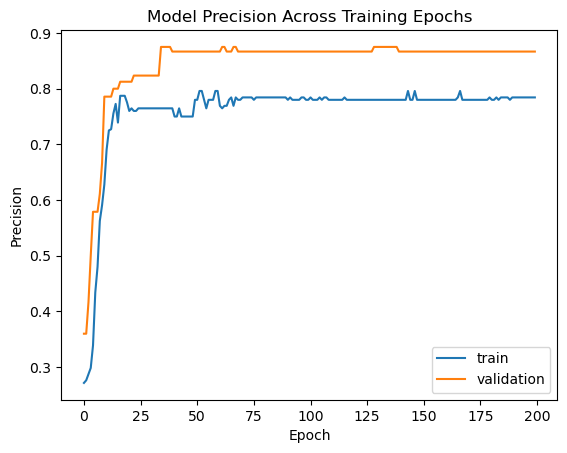

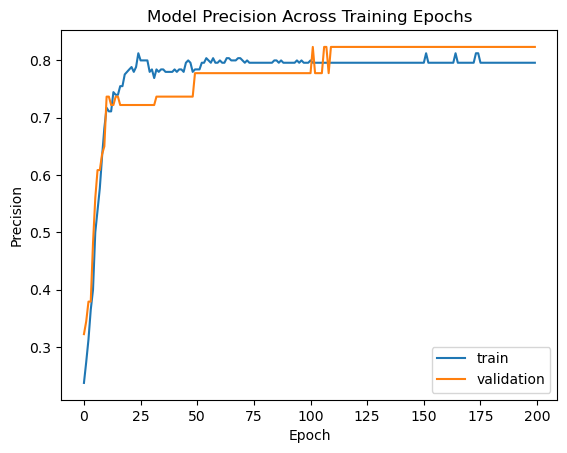

In [ ]:
for history in best_history:
    plot_epochs(history.history, 'precision')

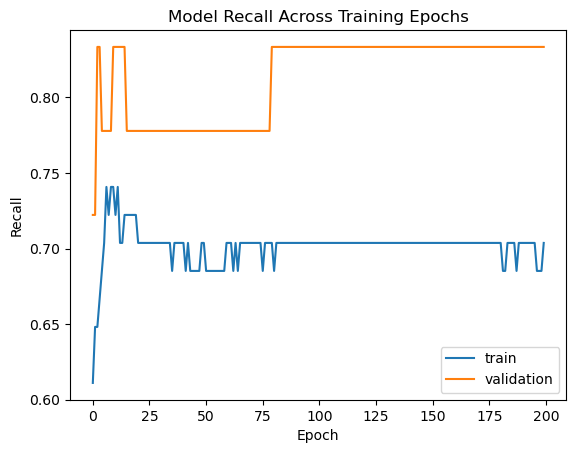

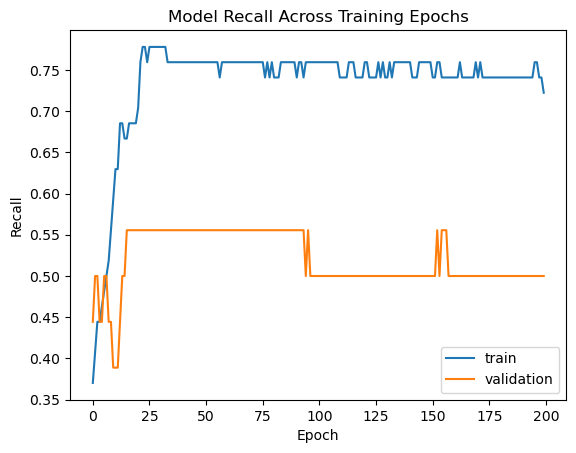

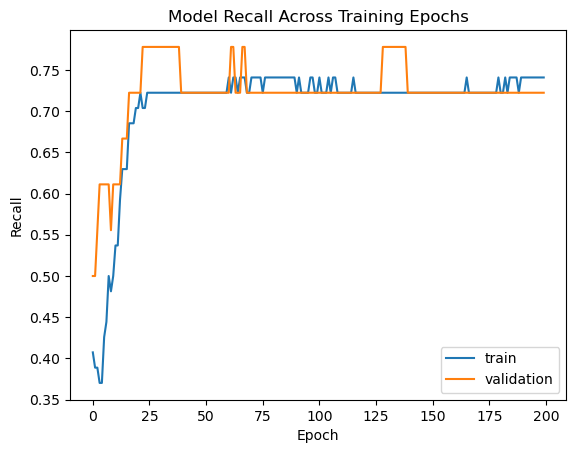

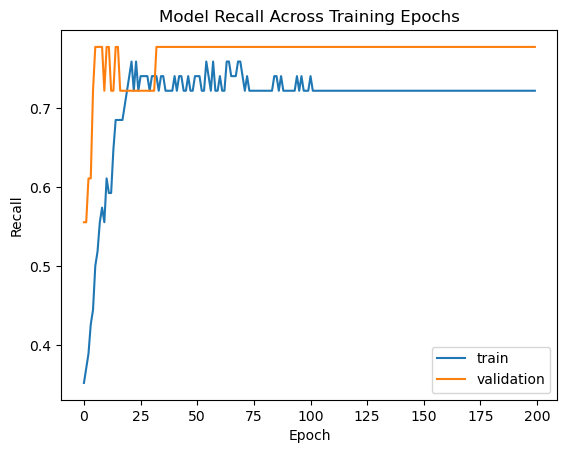

In [ ]:
for history in best_history:
    plot_epochs(history.history, 'recall')

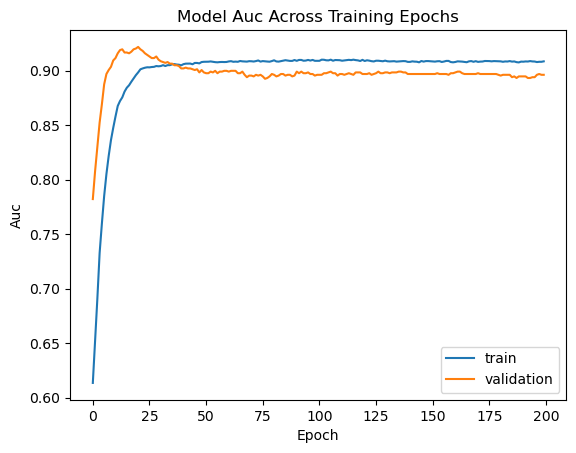

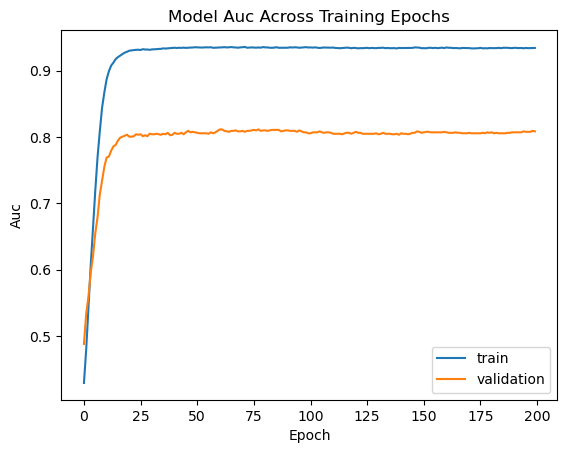

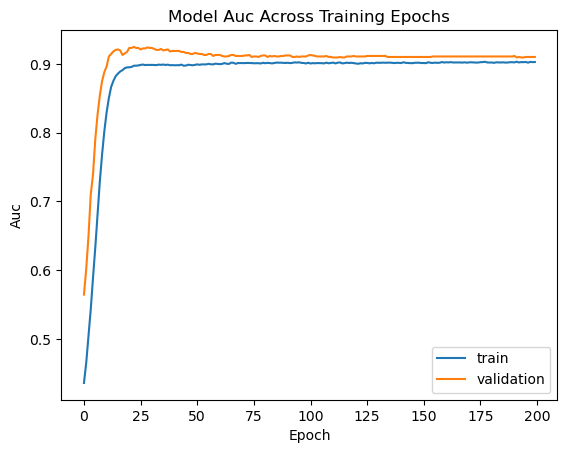

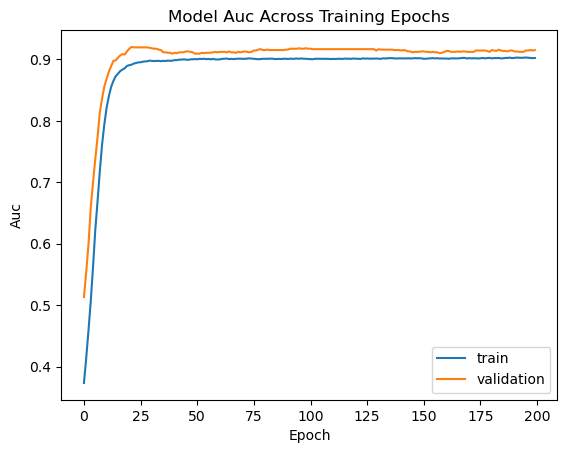

In [ ]:
for history in best_history:
    plot_epochs(history.history, 'auc')

## Track Parameters